In [1]:
import os, sys
ROOT = os.path.abspath("..")
sys.path.append(os.path.join(ROOT, "src"))
import numpy as np
import yaml
import gymnasium as gym
from gym_env.ref_env import Ref, make_env
from helpers import helper as h
from helpers import device as d
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor

In [2]:
h = -16.7
l = -18.0 
high_threshold = h * np.ones(2)
low_threshold  = l * np.ones(2)

In [16]:
def bang_bang_policy(obs):
    evap_actions = np.zeros(2) ### 4 evaporators in total
    room_temps = np.asarray(obs["room_temperatures"]).copy()
    
    for i in range(len(room_temps)):
                if room_temps[i] < low_threshold[i]:
                    evap_actions[i] = 0 ### turn off evaporators in the room if room temp is below lower bound
                elif room_temps[i] >  high_threshold[i]:
                    evap_actions[i] = 1 ### turn on evaporators in the room if room temp is above upper bound
    return evap_actions

In [17]:
def couple_policy(obs):
    evap_actions = np.zeros(2) ### 4 evaporators in total
    room_temps = np.asarray(obs["room_temperatures"]).copy()
    for i in range(len(room_temps)):
        if room_temps[i] >  high_threshold[i]:
            evap_actions = np.ones(2) ### turn on evaporators in the room if room temp is above upper bound
    return evap_actions

In [18]:
def couple_threshold_policy(obs):
    evap_actions = np.zeros(2) ### 4 evaporators in total
    room_temps = np.asarray(obs["room_temperatures"]).copy()
    if any(room_temps > high_threshold):
        evap_actions = np.ones(2) ### turn on evaporators in the room if room temp is above upper bound
    for i in range(len(room_temps)):
        if room_temps[i] <  low_threshold[i]:
            evap_actions[i] = 0 ### turn off evaporators in the room if room temp is below lower bound
    return evap_actions

In [20]:
def convert_action(evap_actions): ### Only support evap action 
    action = 0
    for i in range(len(evap_actions)):
        action += evap_actions[i] * (2 ** i)
    
    return action
    
    
    

In [ ]:
policy = bang_bang_policy


In [23]:
policy = couple_policy


In [25]:
policy = couple_threshold_policy

<Figure size 640x480 with 0 Axes>

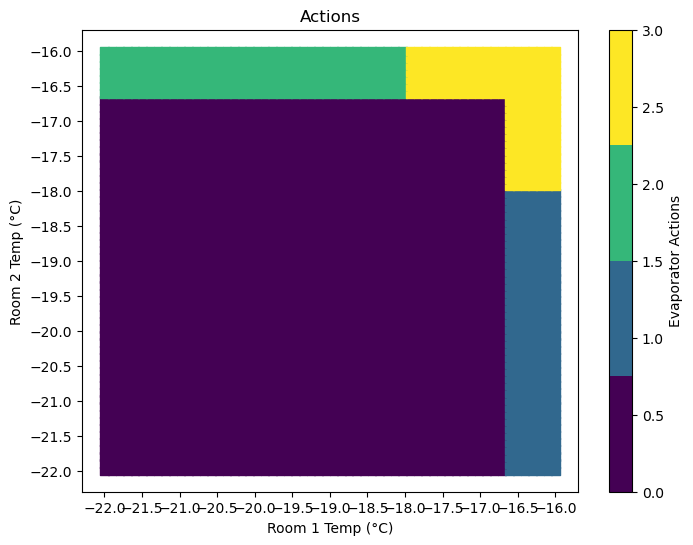

In [32]:
n = 60
room_1 = np.linspace(-22, -16, num=n, dtype=np.float64)
room_2 = np.linspace(-22, -16, num=n, dtype=np.float64)
mesh_x, mesh_y = np.meshgrid(room_1, room_2)
obs_array = np.stack([mesh_x.ravel(), mesh_y.ravel()], axis=1).astype(np.float64)
Ni = obs_array.shape[0]
obs_batch = {"room_temperatures": obs_array}
    
action_batch = np.zeros(shape=(Ni,), dtype=np.int32)

for i in range(Ni):
    obs = {"room_temperatures": obs_array[i, :]}
    action_batch[i] = convert_action(policy(obs))
action_grid = action_batch.reshape((n, n))

from matplotlib.colors import BoundaryNorm
plt.figure()
cmap = plt.get_cmap("viridis", 4)                # 4 discrete colors
norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)
color_map = plt.get_cmap("viridis", 4)  # 4 discrete colors for actions 0-3

plt.figure(figsize=(8, 6))
plt.scatter(mesh_x, mesh_y, c=action_grid[:, :], cmap=color_map, marker='s')
plt.colorbar(label="Evaporator Actions")
plt.title("Actions")
plt.xlabel("Room 1 Temp (°C)")
plt.ylabel("Room 2 Temp (°C)")
plt.xticks(np.arange(-22, -15.5, 0.5))  
plt.yticks(np.arange(-22, -15.5, 0.5))
plt.show()


